### Pro Nutzer gruppierte Pixel ..... ich möchte gern Pixel paarweise vergleichen damit ich gucken kann ob die kollidieren oder nicht

In [1]:
from src.data.dataset_functions import get_dataframe

dataFrame = get_dataframe(True) # sample data only
from src.features.feature_functions import group_dataframe_by_user
groupedFrame = group_dataframe_by_user(dataFrame)

providing ../data/raw/2022_place_canvas_history-000000000050.csv ...
../data/raw/2022_place_canvas_history-000000000050.csv is already in data/raw


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/13 00:58:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
groupedFrame.show(1)

+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|             user_id|count|     collect_list(x)|     collect_list(y)|     collect_list(t)|collect_list(pixel_color)|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|AxBTmhBMbr1sbDw/2...|   20|[1447, 1617, 655,...|[5, 16, 1896, 191...|[184, 1417, 1726,...|     [#FFA800, #FF4500...|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
only showing top 1 row



### Hmmm leider bringen mir die aggregierten Pixel gerade nichts. Ich brauche einzelne Pixel

In [3]:
dataFrame.show(1)

+--------------------+---+----+---+-----------+
|             user_id|  x|   y|  t|pixel_color|
+--------------------+---+----+---+-----------+
|vKtmwRQwAYtw5poO4...|804|1992|  0|    #FF3881|
+--------------------+---+----+---+-----------+
only showing top 1 row



### Ich möchte jeden Pixel mit allen anderen Pixeln vergleichen.. Self Join also! 
Weil ich jedes Pixelpaar nur einmal brauche muss ich Pixel1 - Pixel2 und Pixel2 - Pixel1 wie Duplikate entfernen

...

Idee: ich nutze die Ordnung in der Zeit! Damit gibt es eine feste Reihenfolge von Pixeln in der verglichen wird und Pixel2-Pixel1 kommt nie vor

-> df2.t > df1.t

In [2]:
import pyspark.sql.functions as F
from src.models.models import RZModel

print("Box xy max "+str(RZModel.max_xy_dist))
print("Box t max " +str(RZModel.max_t_dist))

Box xy max 80
Box t max 1200


In [46]:
RZModel.max_xy_dist = 80 # zum rumspielen

In [4]:
selfjoinedFrame = dataFrame.alias('df1').join(dataFrame.alias('df2'),F.col('df1.user_id') == F.col('df2.user_id'),'inner')
selfjoinedFrame = selfjoinedFrame.where('df2.t > df1.t').where('df2.t <= df1.t + 2*'+str(RZModel.max_t_dist))
selfjoinedFrame = selfjoinedFrame.where('Abs(df2.x - df1.x) <= 2*'+str(RZModel.max_xy_dist))
selfjoinedFrame = selfjoinedFrame.where('Abs(df2.y - df1.y) <= 2*'+str(RZModel.max_xy_dist))
selfjoinedFrame = selfjoinedFrame.select(F.col('df1.user_id'),F.col('df1.x').alias("x1"),F.col('df2.x').alias('x2'),F.col('df1.y').alias("y1"),F.col('df2.y').alias('y2'),F.col('df1.t').alias("t1"),F.col('df2.t').alias('t2'),F.col('df1.pixel_color').alias("c1"),F.col('df2.pixel_color').alias('c2'))

In [5]:
selfjoinedFrame.show(5)

+--------------------+---+---+----+----+----+----+-------+-------+
|             user_id| x1| x2|  y1|  y2|  t1|  t2|     c1|     c2|
+--------------------+---+---+----+----+----+----+-------+-------+
|++3l0k1HSXKiAsHkH...|684|668|1270|1211|1058|1381|#D4D7D9|#D4D7D9|
|++3l0k1HSXKiAsHkH...|684|664|1270|1240|1058|1721|#D4D7D9|#9C6926|
|++3l0k1HSXKiAsHkH...|684|667|1270|1240|1058|2057|#D4D7D9|#9C6926|
|++3l0k1HSXKiAsHkH...|684|663|1270|1240|1058|2399|#D4D7D9|#9C6926|
|++3l0k1HSXKiAsHkH...|684|653|1270|1229|1058|2779|#D4D7D9|#FFFFFF|
+--------------------+---+---+----+----+----+----+-------+-------+
only showing top 5 rows



Das sieht schonmal gut aus :) jetzt aggregieren...

In [7]:
import src.features.feature_functions
pixelPaareProNutzer = group_dataframe_by_user(selfjoinedFrame)


In [8]:
pixelPaareProNutzer.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             user_id|count|    collect_list(x1)|    collect_list(x2)|    collect_list(y1)|    collect_list(y2)|    collect_list(t1)|    collect_list(t2)|    collect_list(c1)|    collect_list(c2)|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|FjHp8Fg+uuheibUWk...|   88|[998, 998, 998, 9...|[998, 998, 998, 9...|[1466, 1466, 1466...|[1466, 1466, 1466...|[60, 60, 60, 60, ...|[420, 420, 780, 1...|[#000000, #000000...|[#000000, #000000...|
|zr4zPH9hAud2ggres...|   79|[1335, 1335, 1335...|[1336, 1337, 1338...|[570, 570, 570, 5...|[570, 570, 570, 5...|[286, 286, 286, 2...|[588, 890, 1191, ...|[#000000, #000000...|[#000000, #000000...|
|VcHUE/HttS4Zm0

Das ist jetzt eine Liste von paarweise verbundenen Pixeln pro Nutzer...

Die Liste ist ja wer die meisten Pixelpaare hat. Als Bild wäre es schön von einem Nutzer die Paare zu zeichnen den wir schon haben... Das Beispiel war "AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w=="

gucken wir mal ob wir diese Pixelpaare für einen Nutzer zeichnen können

In [9]:
user_pixel_paare = pixelPaareProNutzer.where(F.col('user_id') == 'AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==').head(1)[0]
print(user_pixel_paare)

Row(user_id='AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', count=30, collect_list(x1)=[1447, 1447, 1447, 1447, 1636, 1636, 1636, 1287, 1287, 1287, 1310, 1310, 1617, 1617, 1617, 1617, 655, 655, 612, 612, 1575, 658, 658, 658, 1403, 777, 1741, 1741, 586, 1611], collect_list(x2)=[1287, 1310, 1575, 1403, 1617, 1575, 1741, 1310, 1403, 1299, 1403, 1299, 1575, 1741, 1611, 1765, 586, 656, 586, 656, 1611, 777, 788, 584, 1299, 788, 1611, 1765, 656, 1765], collect_list(y1)=[5, 5, 5, 5, 21, 21, 21, 8, 8, 8, 10, 10, 16, 16, 16, 16, 1896, 1896, 1917, 1917, 7, 14, 14, 14, 2, 8, 10, 10, 1931, 33], collect_list(y2)=[8, 10, 7, 2, 16, 7, 10, 10, 2, 20, 2, 20, 7, 10, 33, 8, 1931, 1884, 1931, 1884, 33, 8, 11, 26, 20, 11, 33, 8, 1884, 8], collect_list(t1)=[184, 184, 184, 184, 492, 492, 492, 801, 801, 801, 1109, 1109, 1417, 1417, 1417, 1417, 1726, 1726, 1726, 1726, 1726, 2035, 2035, 2035, 2344, 2344, 2344, 2344, 2653, 3269], collect_list(t2)=[801, 1109, 1726, 2344,

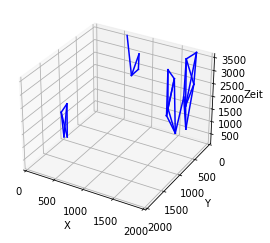

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from src.visualization.visuialization_functions import new_xyt_plot,plot_line

subplot = new_xyt_plot()
for i in np.arange(0,len(user_pixel_paare['collect_list(x1)'])):
    subplot = plot_line([user_pixel_paare['collect_list(x1)'][i],user_pixel_paare['collect_list(x2)'][i]],[user_pixel_paare['collect_list(y1)'][i],user_pixel_paare['collect_list(y2)'][i]],[user_pixel_paare['collect_list(t1)'][i],user_pixel_paare['collect_list(t2)'][i]],color='blue',subplot=subplot,finish=False)

plt.show()

nice! vlt noch die Pixel des Nutzers dazu malen

In [51]:
groupedFrame.show(1)

+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|             user_id|count|     collect_list(x)|     collect_list(y)|     collect_list(t)|collect_list(pixel_color)|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|AxBTmhBMbr1sbDw/2...|   20|[1447, 1617, 655,...|[5, 16, 1896, 191...|[184, 1417, 1726,...|     [#FFA800, #FF4500...|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
only showing top 1 row



In [11]:
from src.visualization.visuialization_functions import plot_pixellist

In [12]:
row = groupedFrame.head(1)[0]
user_id , count ,xs , ys , ts , pixel_color = list(row)

In [1]:
from src.visualization.visuialization_functions import new_xyt_plot
subplot = new_xyt_plot()

subplot = plot_pixellist([xs,ys,ts],color='red',subplot=subplot,finish=False)
for i in np.arange(0,len(user_pixel_paare['collect_list(x1)'])):
    subplot = plot_line([user_pixel_paare['collect_list(x1)'][i],user_pixel_paare['collect_list(x2)'][i]],[user_pixel_paare['collect_list(y1)'][i],user_pixel_paare['collect_list(y2)'][i]],[user_pixel_paare['collect_list(t1)'][i],user_pixel_paare['collect_list(t2)'][i]],color='blue',subplot=subplot,finish=False)

subplot.set_title('Paarweise zusammenhängende Pixel')
subplot.set_ylim([2001,0])
subplot.set_xlim([0,2001])
subplot.set_zlim([0,3601])

plt.savefig('pixelpaare.png',dpi=300)
plt.show()


NameError: name 'new_xyt_plot' is not defined